In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from multiprocessing import Pool
from collections import namedtuple

## Reference : A Simulation Study on the Activation of Cardiac CaMKII delta-Isoform and Its Regulation by Phosphatases

Chiba H, Schneider NS, Matsuoka S, Noma A

Biophys J. 2008 Sep 01; 95(5) 2139-2149

DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018

In [2]:
"""
Reference: 
A Simulation Study on the Activation of Cardiac CaMKIIδ Isoform and ItsRegulation by Phosphatases
Chiba et. al, 2008
DOI: 10.1529/biophysj.107.118505, PMID: 18502812, PMCID: PMC2517018
"""

def _mm(x, k):
    return x / (x + k)

def _hill(x, k, n):
    return _mm(x**n, k**n)

# Calmodulin model
def cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m):
    """ Calmodulin model """
    cam = cam_total - camca1 - camca2 - camca3 - camca4
    v1 = k1p * cam * ca - k1m * camca1
    v2 = k2p * camca1 * ca - k2m * camca2 
    v3 = k3p * camca2 * ca - k3m * camca3
    v4 = k4p * camca3 * ca - k4m * camca4
    dcamca1 = v1 - v2
    dcamca2 = v2 - v3
    dcamca3 = v3 - v4
    dcamca4 = v4
    return [dcamca1, dcamca2, dcamca3, dcamca4]

# CaMKII model
def camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    """ CaMKII model """
    camkii = camkii_total - camkii_camca4 - camkii_p_camca4 - camkii_p
    
    # Association of CaMKII and CaMCa4
    a1 = k_a * camca4 * camkii
    # Association of CaMKII-p and CaMCa4
    c2 = k_a * camca4 * camkii_p
    
    # Dissociation of CaMKII and CaMCa4
    phi_cam = _hill(ca, km_cam, 3)
    a2 = (k_d * phi_cam + k_d_ca * (1 - phi_cam)) * camkii_camca4
     # Dissociation of CaMKII-p and CaMCa4 (1000x slower)
    c1 = (k_d2 * phi_cam + k_d_ca2 * (1 - phi_cam)) * camkii_p_camca4
    
    # Autophosphorylation of CaMKII subunits
    p = 1 - (camkii / camkii_total)**2
    b1 = kcat * p * _mm(atp, km_atp) * camkii_camca4
    
    # Dephosphorylation by phosphorylase (PP1)
    b2 = kcat_pp1 * pp1 * _mm(camkii_p_camca4, km_pp1)
    d1 = kcat_pp1 * pp1 * _mm(camkii_p, km_pp1)
    
    v1 = a1 - a2
    v2 = b1 - b2
    v3 = c1 - c2
    v4 = d1
    dcamkii_camca4 = v1 - v2
    dcamkii_p_camca4 = v2 - v3
    dcamkii_p = v3 - v4
    return [dcamkii_camca4, dcamkii_p_camca4, dcamkii_p]

def rhs(t, y, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1):
    camca1, camca2, camca3, camca4, camkii_camca4, camkii_p_camca4, camkii_p, ca = y
    
    v_cam = cam_sys(camca1, camca2, camca3, camca4, ca, cam_total, k1p, k1m, k2p, k2m, k3p, k3m, k4p, k4m)
    v_camkii = camkii_sys(camkii_camca4, camkii_p_camca4, camkii_p, camca4, ca, camkii_total, atp, pp1, k_a, k_d, k_d_ca, k_d2, k_d_ca2, km_cam, kcat, km_atp, kcat_pp1, km_pp1)
    dca = 0
    return v_cam + v_camkii + [dca] # Merge lists

In [9]:
# Reference constants from the original paper
K1 = 2.5
KM1 = KM2 = 0.05
K2 = 88.25
K3 = 12.5
KM3 = KM4 = 1.25
K4 = 250

K_A = 2.1
K_D_ALPHA = 1.4E-4
K_D_DELTA = 0.5 * K_D_ALPHA
K_D_CA_ALPHA = 1.9E-3
K_D_CA_DELTA = 0.5 * K_D_CA_ALPHA
K_D2_ALPHA = K_D_ALPHA * 1e-3
K_D2_DELTA = K_D_DELTA * 1e-3
K_D2_CA_ALPHA = K_D_CA_ALPHA * 1e-3
K_D2_CA_DELTA = K_D_CA_DELTA * 1e-3
KM_CAM = 3E-5
KCAT_0_ALPHA = 1E-5
KCAT_0_DELTA = 6 * KCAT_0_ALPHA
KCAT_30_ALPHA = 30 * KCAT_0_ALPHA
KCAT_30_DELTA = 6 * KCAT_30_ALPHA
KCAT_37_ALPHA = 3 * KCAT_30_ALPHA
KCAT_37_DELTA = 6 * KCAT_37_ALPHA
KM_ATP = 19.1E-3
KCAT_PP1 = 1.72E-3
KM_PP1 = 11.0E-3

# Substance concentrations
CAM_TOTAL = 6e-3
PP1 = 0.1E-3
CAMKII_TOTAL = 0.1E-3
ATP = 0.1


# Params in the ODE
params = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': K_D2_DELTA,
           'k_d_ca2': K_D2_CA_DELTA,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}

# Other constants
T_END = 2000000
DELTA = 0.01
NUM_STEPS=100
ts = np.linspace(0, T_END)

# Initial conditions
y0 = [0.0, 0.0, 0.0, 0.0] + [0.0, 0.0, 0.0] + [1e-3]

# Ranges are 4 orders of magnitude apart, except for some linearly-spaced ones or strictly constant ones
param_ranges = {name: params[name] * np.logspace(-2, 2, num=NUM_STEPS) for name in params}
param_ranges['atp'] = np.linspace(0, 1, num=NUM_STEPS)
# Calcium ranges (0.1μM ~ 10μM)
ca_concs = np.logspace(np.log10(1e-4), np.log10(1e-2), num=NUM_STEPS)
y0s = [[0.0] * 7 + [ca] for ca in ca_concs]

In [10]:
def _act_camk(sol, params):
    yend = sol[-1]
    return np.sum(yend[4:7]) / params['camkii_total']

def _phosphorylation(sol, params, KM_CAMKII = 0.15):
    """
    Get phosphorylation proportion from active CaMKII level.
    KM = 0.15 from the ORd model
    """
    camkii_act = _act_camk(sol, params)
    return _mm(camkii_act, KM_CAMKII)

# Relative sensitivity analysis

$Sensitivity = (\frac{dP}{P}) / (\frac{dS}{S})$

* In = Parameter(s)

* Out = Unphosphorylated proportion of CaMKII targets (complex I, mitochondrial creatine kinase)

Varying one parameter across 8 orders of magnitude at a time, plus varying calcium concentration, yielding a 2D sensitivity heat map.

In [11]:
sol = odeint(lambda y, t: rhs(t, y, **params), y0, ts) 

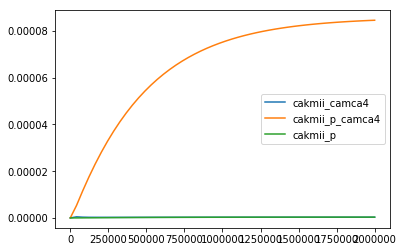

In [12]:
plt.figure()
#plt.plot(ts, sol[:, 1], label="camca1")
plt.plot(ts, sol[:, 4], label="cakmii_camca4")
plt.plot(ts, sol[:, 5], label="cakmii_p_camca4")
plt.plot(ts, sol[:, 6], label="cakmii_p")
plt.legend(loc="best")

In [13]:
# Sensitivity for Calcium
phosphorylated = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII = 0.15) for y0 in y0s])
y0s_ca = [[0.0] * 7 + [ca * (1 + DELTA)] for ca in ca_concs]
phosphorylated_ca = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII = 0.15) for y0 in y0s_ca])
sensitivity = (phosphorylated_ca - phosphorylated) / DELTA

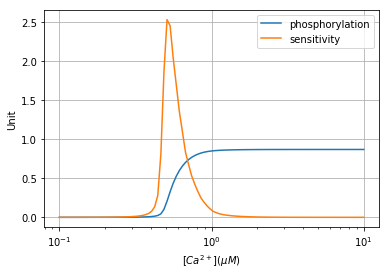

In [14]:
# dynamic range: Ca = 0.4~1 μM
plt.figure()
plt.semilogx(ca_concs * 1e3, phosphorylated, label="phosphorylation")
plt.semilogx(ca_concs * 1e3, sensitivity, label="sensitivity")
plt.xlabel(r'$[Ca^{2+}](μM)$')
plt.ylabel('Unit')
plt.legend(loc='best')
plt.grid(True)

Relative sensitivity was noted between 0.4 $\mu M$ and 0.9 $\mu M$

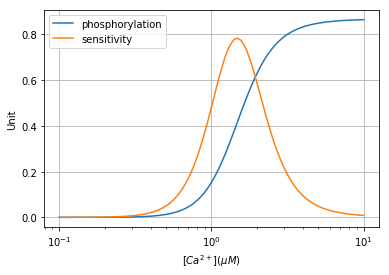

In [15]:
# Calcium sensitivity without ATP
# Shifted to right, wider, less amplitude
params_atp = params.copy()
params_atp['atp'] = 0.0
phosphorylated = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params_atp), y0, ts), params_atp, KM_CAMKII = 0.15) for y0 in y0s])
phosphorylated_ca = np.asarray([_phosphorylation(odeint(lambda y, t: rhs(t, y, **params_atp), y0, ts), params_atp, KM_CAMKII = 0.15) for y0 in y0s_ca])
sensitivity = (phosphorylated_ca - phosphorylated) / DELTA
plt.figure()
plt.semilogx(ca_concs * 1e3, phosphorylated, label="phosphorylation")
plt.semilogx(ca_concs * 1e3, sensitivity, label="sensitivity")
plt.xlabel(r'$[Ca^{2+}](μM)$')
plt.ylabel('Unit')
plt.legend(loc='best')
plt.grid(True)

Relative sensitivity was noted between 0.8 $\mu M$ and 10 $\mu M$

In [16]:
def calc_sensitivities(param_old, param_name, param_val, rhs, ca_concs, T_END=2000000, DELTA=0.01):
    """ Generalized sensitivity map function """
    params = param_old.copy()
    params[param_name] = param_val
    y0s = [[0.0] * 7 + [ca] for ca in ca_concs]
    ts = np.linspace(0, T_END)
    phosphorylated = [_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII=0.15) for y0 in y0s]
    phosphorylated = np.asarray(phosphorylated)
    params[param_name] = param_val * (1 + DELTA)
    phosphorylated_new = [_phosphorylation(odeint(lambda y, t: rhs(t, y, **params), y0, ts), params, KM_CAMKII=0.15) for y0 in y0s]
    phosphorylated_new = np.asarray(phosphorylated_new)
    sensitivities = (phosphorylated_new - phosphorylated) / DELTA
    return sensitivities

In [17]:
def plot_sensitivities(sensitivities, ca_concs, param_ranges, param_name, log_scale=True, SCALE=1.0):
    plt.figure()
    # min_sense = np.min(sensitivities)
    # max_sense = np.max(sensitivities)
    # sense_range = max(abs(min_sense), abs(max_sense))
    plt.pcolormesh(ca_concs * 1e3, param_ranges[param_name], sensitivities, cmap=plt.cm.bwr, vmax=SCALE, vmin=-SCALE)
    plt.xlabel(r'$[Ca^{2+}]( \mu M )$')
    plt.xscale('log')
    if log_scale:
        plt.yscale('log')
    plt.ylabel(param_name.upper())
    return plt.colorbar()

The code was running on Python 3.7 in the Jupyter notebook on a workstation with dual Xeon E5-2620 CPUs.

In [18]:
# Generator of arguments
args = {name: [(params, name, param_val, rhs, ca_concs, T_END, DELTA) for param_val in param_ranges[name]] for name in params}

In [19]:
# Multiprocessing (using all CPU cores)
pool = Pool()
param_sensitivities = {}
for name in params:
    param_sensitivities[name] = np.asarray(pool.starmap(calc_sensitivities, args[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
print('Finished')

cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
k_d2 is completed.
k_d_ca2 is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


/home/sosiristseng/miniconda3/envs/sci/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


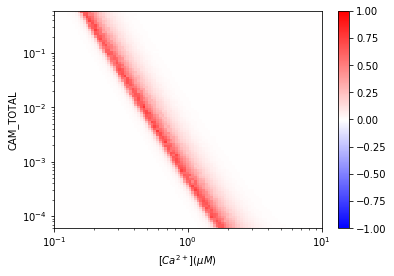

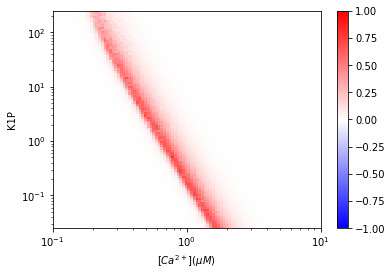

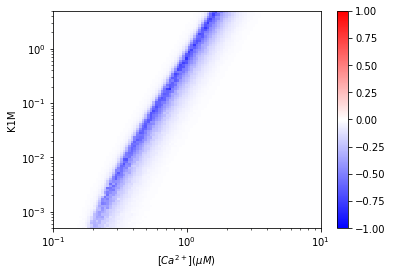

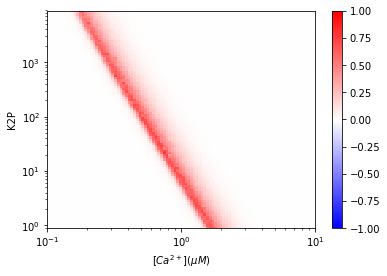

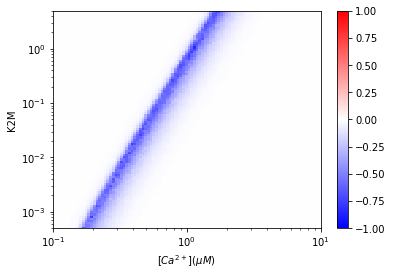

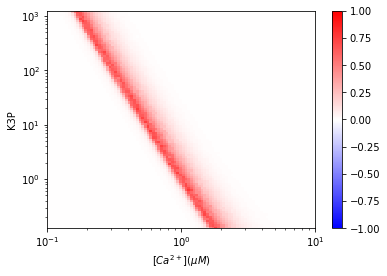

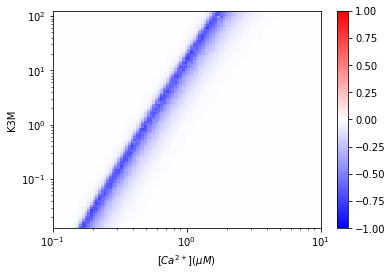

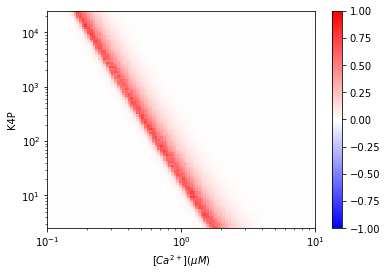

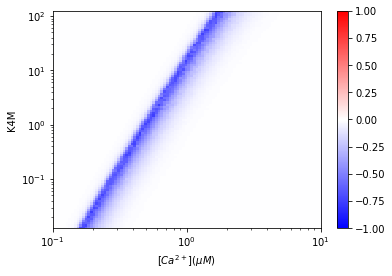

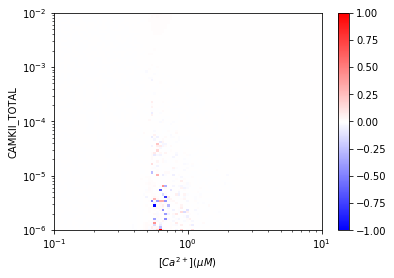

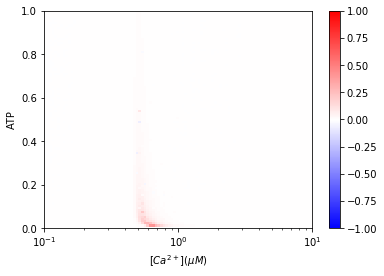

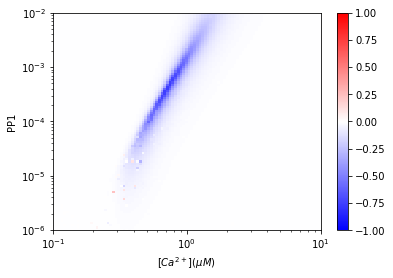

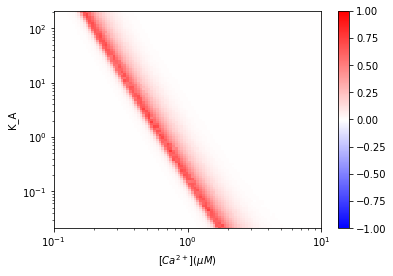

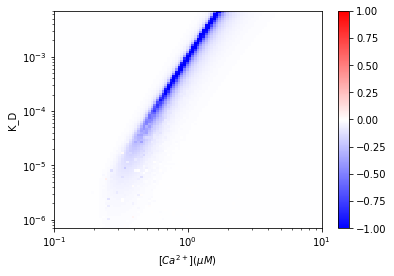

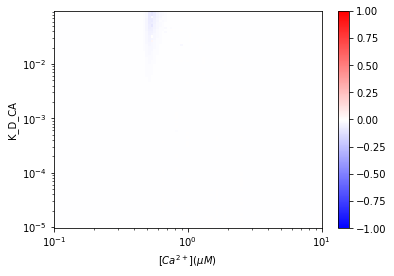

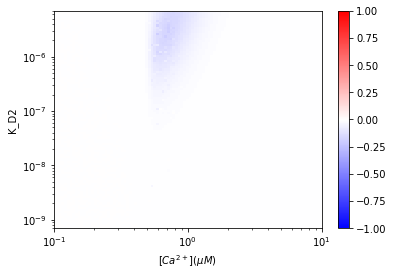

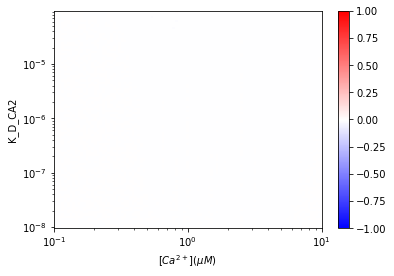

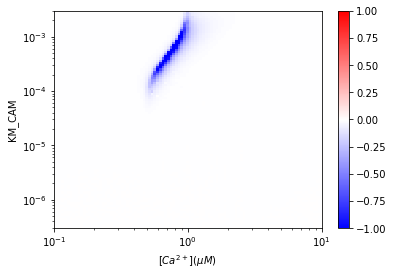

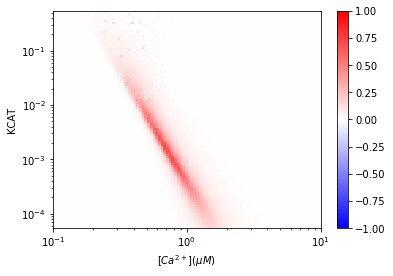

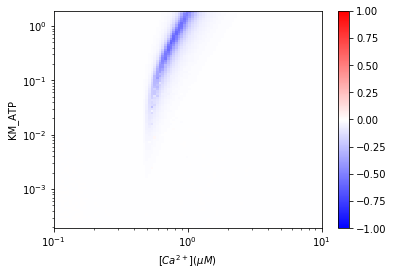

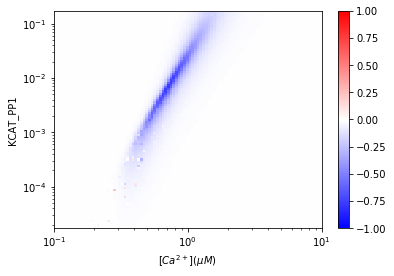

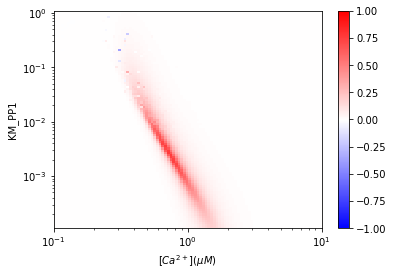

In [20]:
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities[name], ca_concs, param_ranges, name, name not in ('atp'))

In [24]:
# Disable C1 => K_DISSO2 = K_DISSO_CA2 = 0
# Params for the model
params_noc1 = { 'cam_total': CAM_TOTAL,
           'k1p': K1,
           'k1m': KM1,
           'k2p': K2,
           'k2m': KM2,
           'k3p': K3,
           'k3m': KM3,
           'k4p': K4,
           'k4m': KM4,
           'camkii_total': CAMKII_TOTAL,
           'atp': ATP,
           'pp1': PP1,
           'k_a': K_A,
           'k_d': K_D_DELTA,
           'k_d_ca': K_D_CA_DELTA,
           'k_d2': 0.0,
           'k_d_ca2': 0.0,
           'km_cam': KM_CAM,
           'kcat': KCAT_37_DELTA,
           'km_atp': KM_ATP,
           'kcat_pp1': KCAT_PP1,
           'km_pp1': KM_PP1}

# Generator of arguments
args_noc1 = {name: [(params_noc1, name, param_val, rhs, ca_concs, T_END, DELTA) for param_val in param_ranges[name]] for name in params if (name != 'k_d2' and name != 'k_d_ca2')}

In [25]:
args_noc1.keys()

dict_keys(['cam_total', 'k1p', 'k1m', 'k2p', 'k2m', 'k3p', 'k3m', 'k4p', 'k4m', 'camkii_total', 'atp', 'pp1', 'k_a', 'k_d', 'k_d_ca', 'km_cam', 'kcat', 'km_atp', 'kcat_pp1', 'km_pp1'])

In [27]:
# Multiprocessing (using all CPU cores)
param_sensitivities_noc1 = {}
for name in args_noc1:
    param_sensitivities_noc1[name] = np.array(pool.starmap(calc_sensitivities, args_noc1[name])).reshape(-1, ca_concs.shape[0])
    print(name, 'is completed.')
print('Finished')

cam_total is completed.
k1p is completed.
k1m is completed.
k2p is completed.
k2m is completed.
k3p is completed.
k3m is completed.
k4p is completed.
k4m is completed.
camkii_total is completed.
atp is completed.
pp1 is completed.
k_a is completed.
k_d is completed.
k_d_ca is completed.
km_cam is completed.
kcat is completed.
km_atp is completed.
kcat_pp1 is completed.
km_pp1 is completed.
Finished


KeyError: 'k_d2'

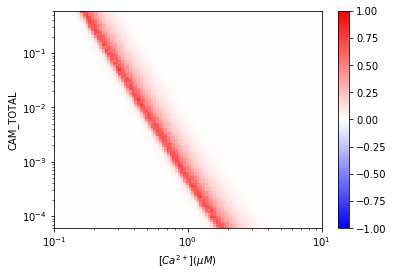

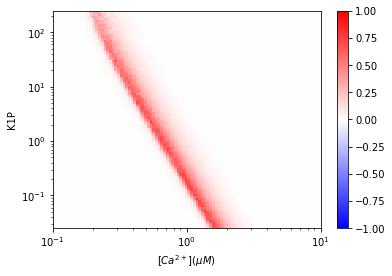

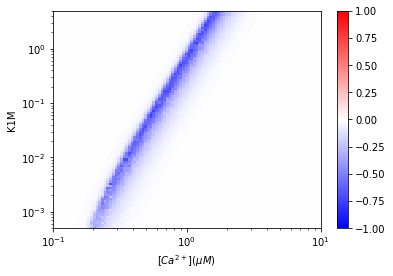

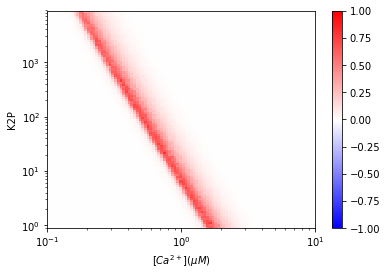

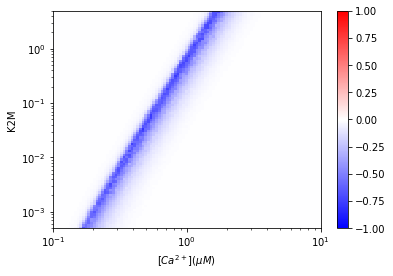

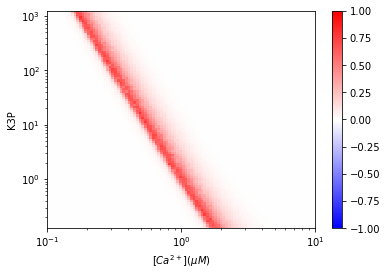

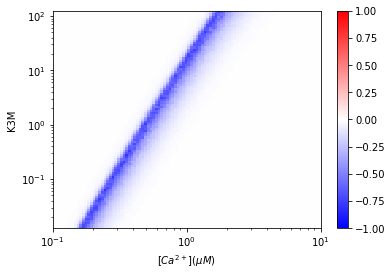

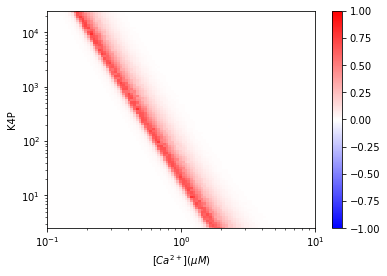

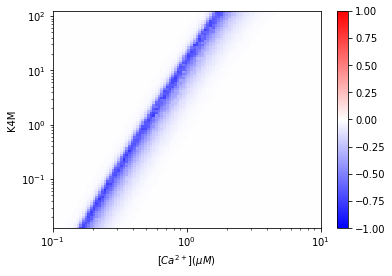

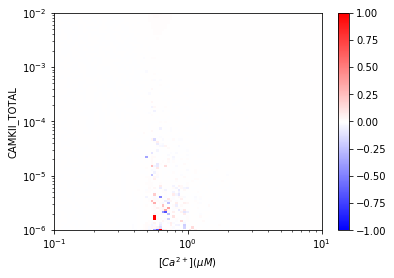

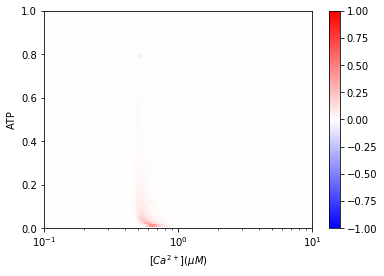

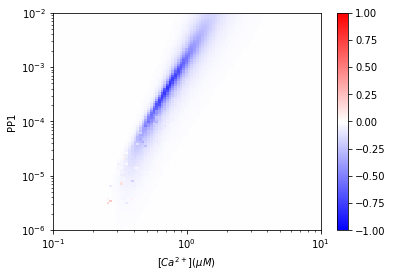

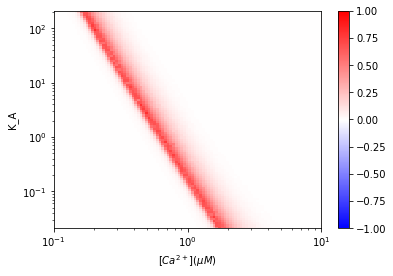

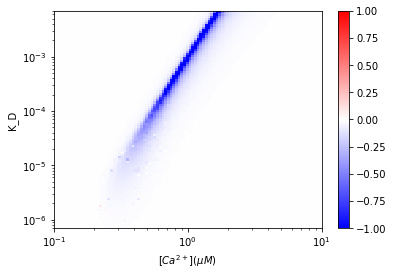

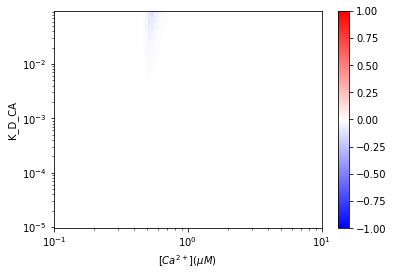

In [28]:
# Plot sensitivities
for name in param_sensitivities:
    plot_sensitivities(param_sensitivities_noc1[name], ca_concs, param_ranges, name, name not in ('atp'))